In [13]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from tqdm import tqdm

In [16]:
input_path = '../../../siads591 data/gabbard/'
output_path = './'

bitrate = 1000
dpi = 300
fps = 60
freq = '1D'
use_slice = slice(None, None, None)

input_file_name = 'all_debris_1D.pkl'
output_file_name = 'gabbard_all_debris_1D_60fps.mp4'

# set this to a specific frame number to draw only 1 frame in the notebook
# Set None generate full video
draw_one_frame = None

In [3]:
df = pd.read_pickle(f'{input_path}{input_file_name}')
display(df.info())
display(df.head(4))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87963558 entries, 1960-08-17 to 2021-01-19
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   NORAD_CAT_ID  uint64 
 1   PERIOD        float32
 2   APOAPSIS      float32
 3   PERIAPSIS     float32
dtypes: float32(3), uint64(1)
memory usage: 2.3 GB


None

,NORAD_CAT_ID,PERIOD,APOAPSIS,PERIAPSIS
EPOCH,,,,
1960-08-17,51,118.252220,1690.064575,1514.787598
1960-08-18,51,118.256447,1690.092163,1515.144165
1960-08-19,51,118.260666,1690.119629,1515.500732
1960-08-20,51,118.264893,1690.147217,1515.857300
1960-08-21,51,118.269112,1690.174805,1516.213745
...,...,...,...,...
2021-01-17,47247,127.838501,3335.234863,720.967529
2021-01-18,47247,127.834503,3331.443359,724.413513
2021-01-17,47308,90.419502,390.523010,199.667999


In [17]:
dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
dates = dates[use_slice]
print(f'{len(dates)} frames')

22071

100%|██████████| 22072/22072 [2:01:11<00:00,  3.04it/s]  


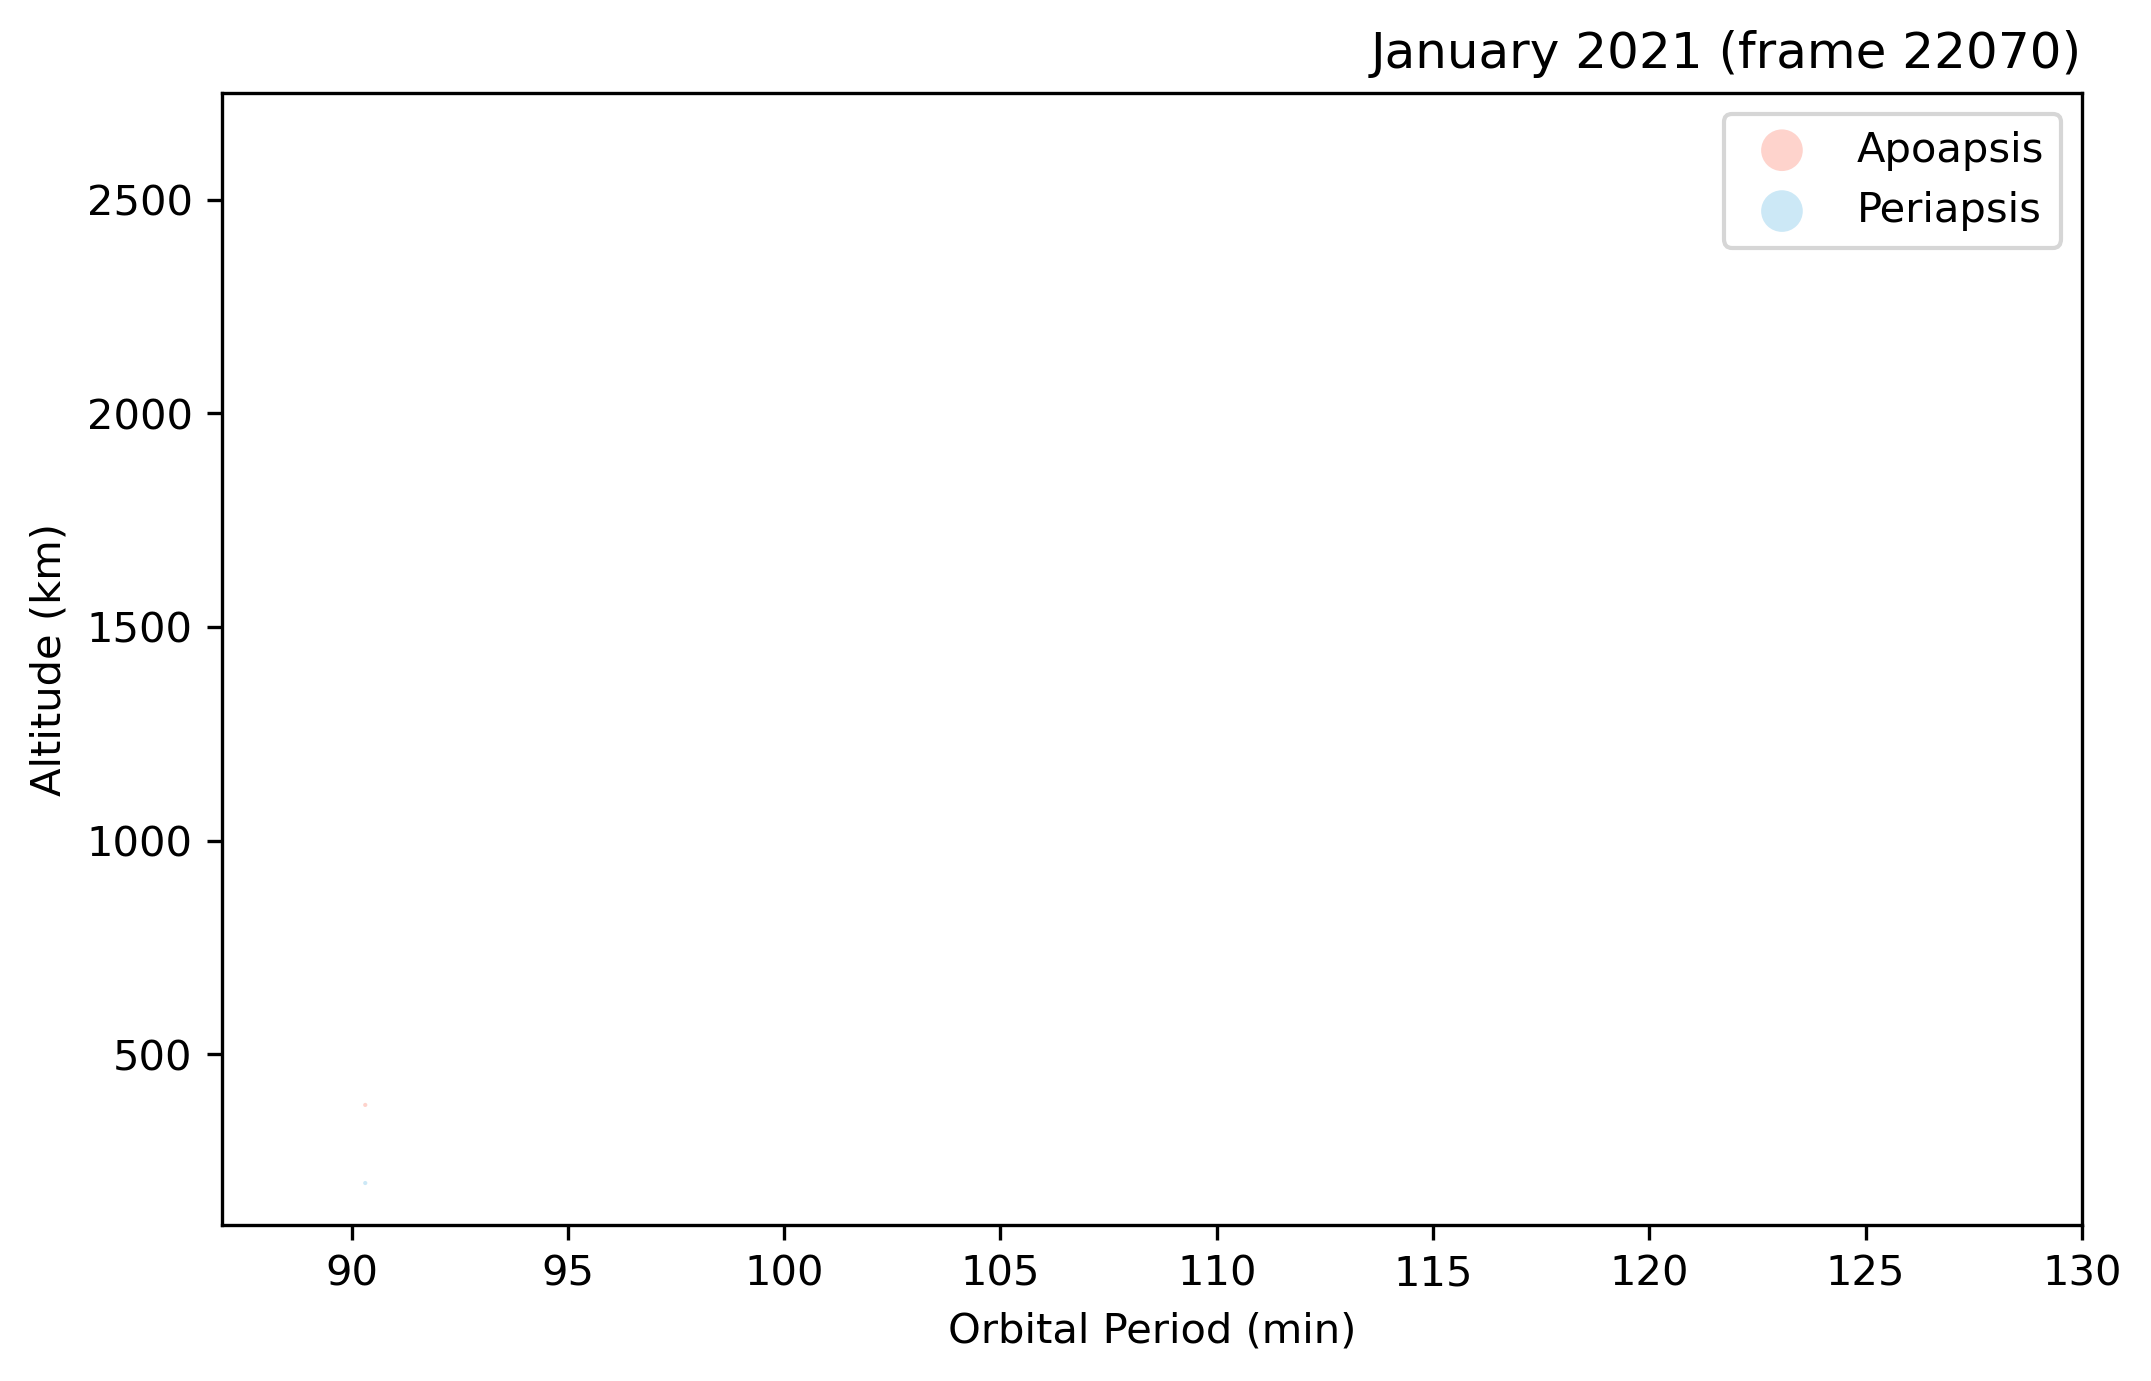

In [20]:
fig, ax = plt.subplots(dpi=dpi, figsize=(8,5))

ax.set_xlim(87,130)
ax.set_ylim(100,2750)
ax.set_xlabel("Orbital Period (min)")
ax.set_ylabel("Altitude (km)")
artists = []

def plot_it(ax,e):
    global df
    cdf = df[df.index==e]
    apo = ax.scatter(cdf.PERIOD, cdf.APOAPSIS, color='#fe2700', marker='o', edgecolors='none', alpha=0.2, s=1, label="Apoapsis")
    peri = ax.scatter(cdf.PERIOD, cdf.PERIAPSIS, color='#038fd5', marker='o', edgecolors='none', alpha=0.2, s=1, label="Periapsis")
    plt.legend(loc="upper right", numpoints=1, fontsize=10, markerscale=10)
    return [apo,peri]

def update(f):
    global pbar, artists, yr
    i, date = f
    ax.set_title(f"{date.month_name()} {date.year} (frame {i})", loc='right')
    for a in artists:
        a.remove()
    artists = plot_it(ax,date)
    pbar.update(1)

if type(draw_one_frame) == int:
    pbar = tqdm(total=1, position=0, leave=True)
    update((draw_one_frame,dates[draw_one_frame]))
    pbar.close()
else:
    pbar = tqdm(total=len(dates)+1, position=0, leave=True)
    ani = FuncAnimation(fig, update, list(enumerate(dates)))
    writervideo = FFMpegWriter(fps=fps, bitrate=bitrate)
    ani.save(f'{output_path}{output_file_name}', writer=writervideo, dpi=dpi)
    pbar.close()